In [27]:
import os
import zarr
from config import DATA_DIR, TARGET_DIR
import numpy as np

def process_experiment_runs(base_dir):
    # Dictionnaire pour stocker les résultats par TS
    data_results = {}

    # Parcourir tous les sous-dossiers dans ExperimentRuns
    for ts_folder in os.listdir(base_dir):
        ts_path = os.path.join(base_dir, ts_folder)

        # Vérifier si le dossier contient un fichier Zarr
        zarr_path = os.path.join(ts_path, "VoxelSpacing10.000/denoised.zarr")
        if os.path.exists(zarr_path):
            print(f"Traitement de {ts_folder}...")

            # Charger le groupe Zarr
            zgroup = zarr.open_group(zarr_path, mode='r')
            
            # Visualiser l'arborescence
            print(f"Arborescence pour {ts_folder}:")
            print(zgroup.tree())
            
            # Dictionnaire pour stocker les données de ce TS
            ts_data = {}

            # Parcourir les sous-groupes (0, 1, 2, ...)
            for subgroup_key in zgroup.keys():
                subgroup = zgroup[subgroup_key]

                # Extraire les métadonnées et les données
                ts_data[subgroup_key] = {
                    "attrs": dict(subgroup.attrs),  # Convertir les métadonnées en dictionnaire
                    "info": subgroup.info,
                    "data": subgroup[:],  # Charger les données complètes
                }

            # Ajouter les données au dictionnaire global
            data_results[ts_folder] = ts_data

    return data_results




# Traiter les tomogrammes
all_data = process_experiment_runs(DATA_DIR)

# Sauvegarder les résultats ou continuer l'analyse
print("Traitement terminé. Résumé des données extraites :")
for ts_name, ts_content in all_data.items():
    print(f"- {ts_name}: {len(ts_content)} sous-groupes traités.")


Traitement de TS_5_4...
Arborescence pour TS_5_4:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement de TS_69_2...
Arborescence pour TS_69_2:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement de TS_6_4...
Arborescence pour TS_6_4:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement de TS_6_6...
Arborescence pour TS_6_6:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement de TS_73_6...
Arborescence pour TS_73_6:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement de TS_86_3...
Arborescence pour TS_86_3:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement de TS_99_9...
Arborescence pour TS_99_9:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Traitement terminé. Résumé des données extraites :
- TS_5_4: 3 sous-groupes traités.
- TS_69_2: 3 sous-groupes traités.
- TS_6_4: 3 sous-groupes traités.
- TS_6_6: 3 sous-groupes traités.
- TS_73_6: 3 sous-groupes traités.
- TS_86_3: 3 sous-groupes traités.
- TS_99_9: 3 sous-groupes traités.


In [28]:
all_data.keys()

dict_keys(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9'])

In [29]:
all_data['TS_5_4'].keys()

dict_keys(['0', '2', '1'])

In [30]:
all_data['TS_5_4']['0']['data']

array([[[-1.0589503e-08,  1.5891337e-06,  8.6985551e-07, ...,
          1.2546960e-06,  2.7620436e-07, -9.6554413e-07],
        [-4.9929668e-07,  2.7837150e-06,  3.0947467e-06, ...,
          2.8480628e-07, -8.9094044e-08, -1.4401762e-06],
        [-1.0891541e-06,  1.5427659e-06,  1.4145429e-06, ...,
          1.8715558e-07, -5.1522932e-07, -1.3863324e-06],
        ...,
        [-6.9335545e-07,  3.5703101e-07,  8.0947825e-07, ...,
         -1.4218481e-06, -9.1161525e-08, -1.2515941e-06],
        [-4.2106151e-07,  2.2317974e-07,  8.7088415e-07, ...,
         -2.5142091e-07,  4.4749459e-07,  3.5609071e-07],
        [-2.6293966e-07, -2.7313038e-07, -5.7560578e-07, ...,
          7.9891106e-07,  4.1823807e-07,  1.9056137e-07]],

       [[-8.9148364e-07,  1.9433514e-06,  4.5870165e-06, ...,
          2.9067949e-06,  8.9173477e-07, -1.3247987e-06],
        [-1.5419438e-06,  3.6550177e-06,  8.8251591e-06, ...,
         -5.1537575e-07, -6.8805934e-07, -1.8712533e-06],
        [-2.2441336e-06, 

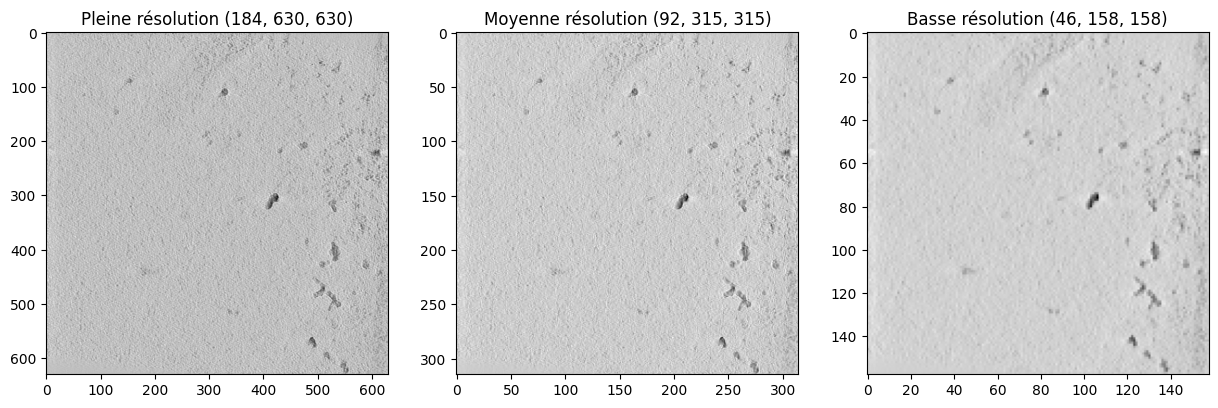

In [31]:
import matplotlib.pyplot as plt

# Afficher une coupe z=0 pour chaque résolution
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(all_data['TS_5_4']['0']['data'][0,:,:], cmap='gray')
axs[0].set_title("Pleine résolution (184, 630, 630)")
axs[1].imshow(all_data['TS_5_4']['1']['data'][0,:,:], cmap='gray')
axs[1].set_title("Moyenne résolution (92, 315, 315)")
axs[2].imshow(all_data['TS_5_4']['2']['data'][0,:,:], cmap='gray')
axs[2].set_title("Basse résolution (46, 158, 158)")
plt.show()

In [32]:
import json

def load_targets(base_path):
    # Dictionnaire pour stocker les informations de chaque tomogramme
    target_data = {}

    # Parcourir tous les dossiers dans le chemin de base (numéros de tomogrammes)
    for tomogram_folder in os.listdir(base_path):
        tomogram_path = os.path.join(base_path, tomogram_folder)

        # Vérifier si un dossier "Picks" existe dans le tomogramme
        picks_path = os.path.join(tomogram_path, "Picks")
        if not os.path.exists(picks_path):
            print(f"Pas de dossier 'Picks' dans {tomogram_folder}")
            continue

        # Parcourir tous les fichiers JSON dans le dossier "Picks"
        for json_file in os.listdir(picks_path):
            if json_file.endswith(".json"):
                json_path = os.path.join(picks_path, json_file)

                # Charger le fichier JSON
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Extraire le nom de la molécule et la localisation des points
                molecule_name = data.get("pickable_object_name", "inconnu")
                points = data.get("points", [])

                # Ajouter les informations au dictionnaire
                if tomogram_folder not in target_data:
                    target_data[tomogram_folder] = {}

                # Sauvegarder les données pour chaque molécule dans le tomogramme
                target_data[tomogram_folder][molecule_name] = points

    return target_data

# Charger les targets
all_targets = load_targets(TARGET_DIR)

# Affichage des données chargées
print("Résumé des données de targets :")
for tomogram, molecules in all_targets.items():
    print(f"- {tomogram}: {len(molecules)} molécules trouvées")
    for molecule, points in molecules.items():
        print(f"  * {molecule}: {len(points)} points")


Résumé des données de targets :
- TS_5_4: 6 molécules trouvées
  * apo-ferritin: 46 points
  * beta-amylase: 10 points
  * beta-galactosidase: 12 points
  * ribosome: 31 points
  * thyroglobulin: 30 points
  * virus-like-particle: 11 points
- TS_69_2: 6 molécules trouvées
  * apo-ferritin: 35 points
  * beta-amylase: 12 points
  * beta-galactosidase: 16 points
  * ribosome: 37 points
  * thyroglobulin: 34 points
  * virus-like-particle: 9 points
- TS_6_4: 6 molécules trouvées
  * apo-ferritin: 58 points
  * beta-amylase: 9 points
  * beta-galactosidase: 12 points
  * ribosome: 74 points
  * thyroglobulin: 30 points
  * virus-like-particle: 10 points
- TS_6_6: 6 molécules trouvées
  * apo-ferritin: 41 points
  * beta-amylase: 14 points
  * beta-galactosidase: 11 points
  * ribosome: 23 points
  * thyroglobulin: 35 points
  * virus-like-particle: 19 points
- TS_73_6: 6 molécules trouvées
  * apo-ferritin: 95 points
  * beta-amylase: 12 points
  * beta-galactosidase: 14 points
  * ribosom

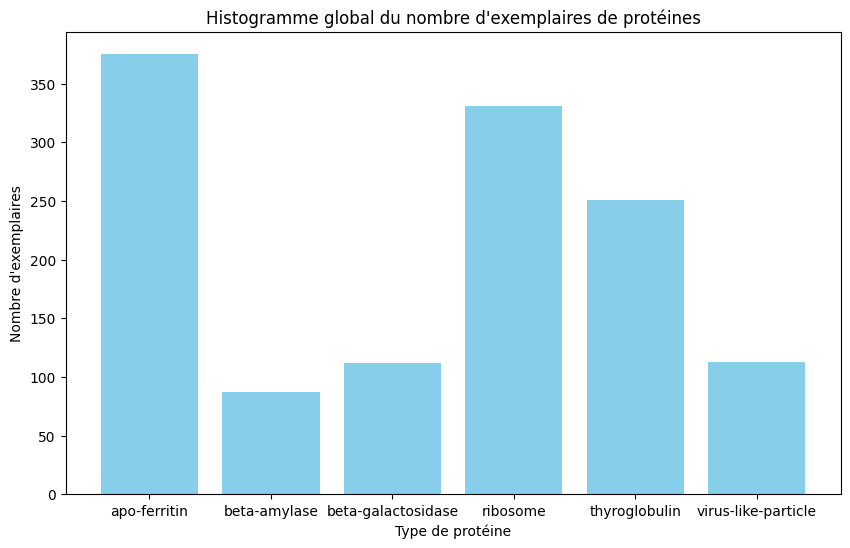

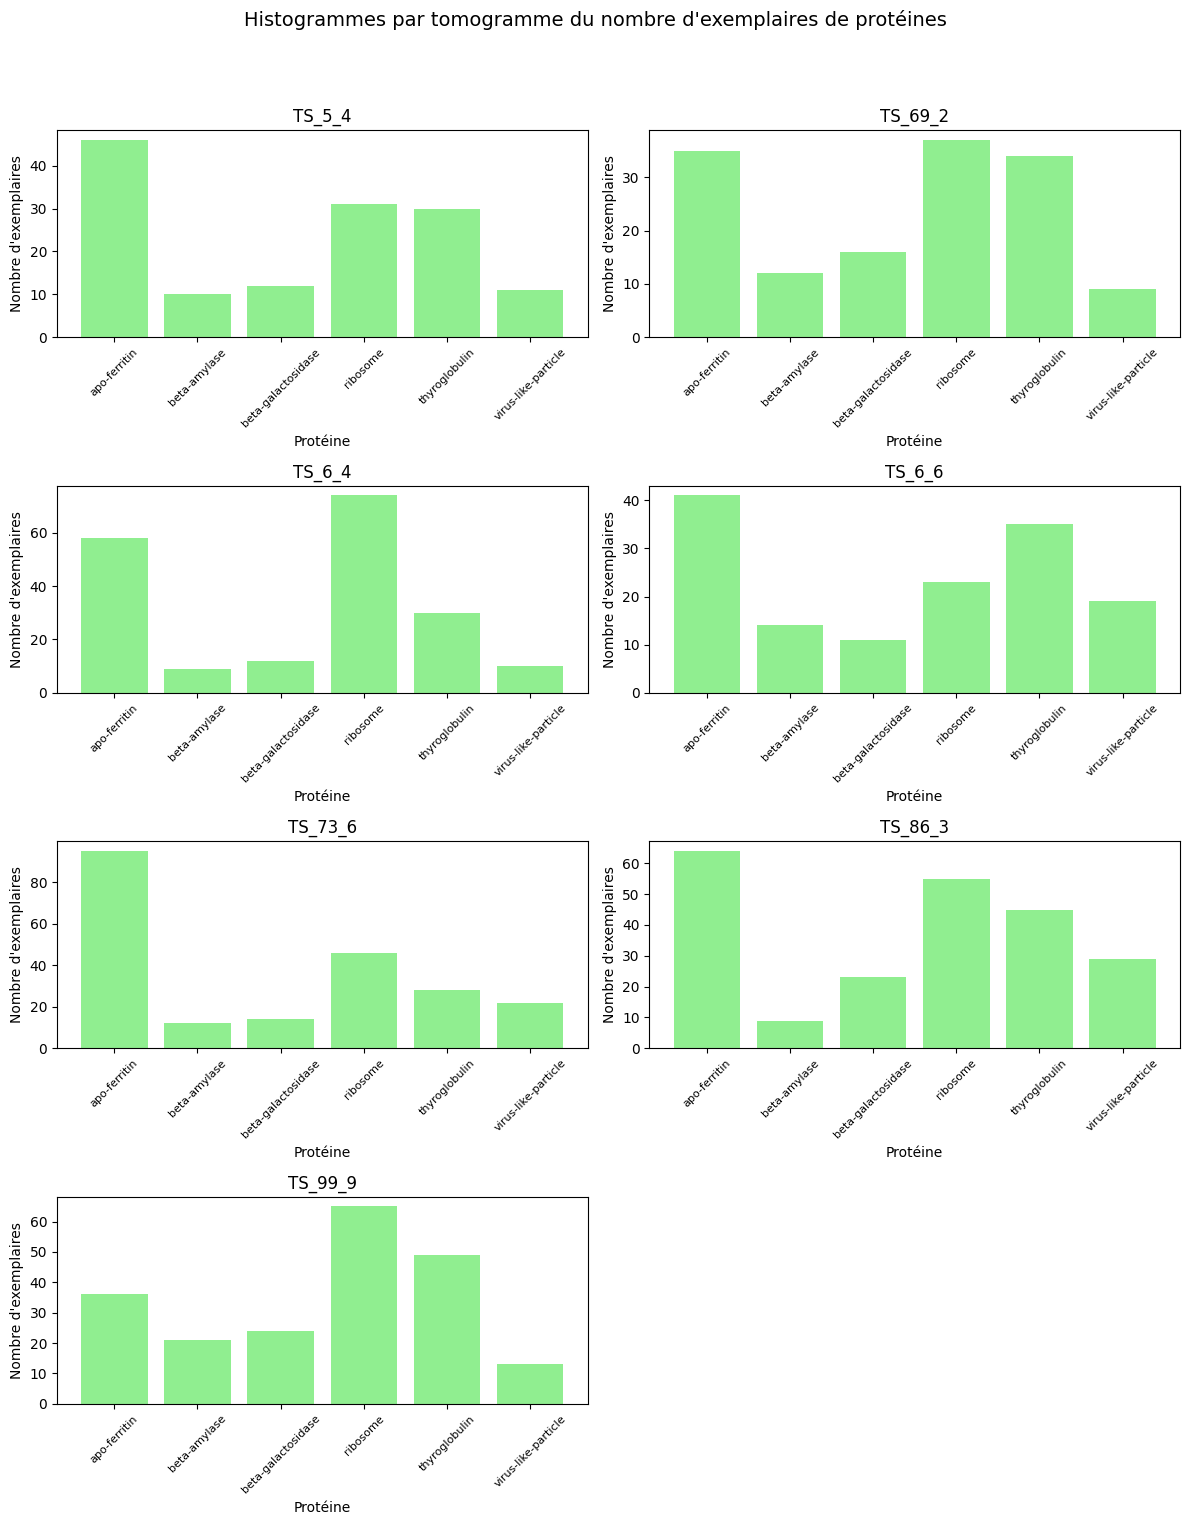

In [33]:
import matplotlib.pyplot as plt
import math

# --- Histogramme global ---
global_counts = {}
for tomogram, molecules in all_targets.items():
    for molecule, points in molecules.items():
        global_counts[molecule] = global_counts.get(molecule, 0) + len(points)

plt.figure(figsize=(10,6))
plt.bar(global_counts.keys(), global_counts.values(), color='skyblue')
plt.xlabel("Type de protéine")
plt.ylabel("Nombre d'exemplaires")
plt.title("Histogramme global du nombre d'exemplaires de protéines")
plt.show()

# --- Histogrammes détaillés par tomogramme ---
# Déterminer le nombre de tomogrammes à afficher
num_tomograms = len(all_targets)
# Choisir une disposition en grille adaptée (par exemple 2 colonnes si plus de 2 tomogrammes)
cols = 2
rows = math.ceil(num_tomograms / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*4), squeeze=False)

# Parcourir les tomogrammes et tracer l'histogramme pour chacun
tomogram_names = list(all_targets.keys())
for idx, tomogram in enumerate(tomogram_names):
    row = idx // cols
    col = idx % cols
    ax = axes[row][col]
    
    # Calculer le nombre d'exemplaires pour chaque protéine dans ce tomogramme
    counts = {molecule: len(points) for molecule, points in all_targets[tomogram].items()}
    
    ax.bar(counts.keys(), counts.values(), color='lightgreen')
    ax.set_title(tomogram)
    ax.set_xlabel("Protéine")
    ax.set_ylabel("Nombre d'exemplaires")
    # Rotation des étiquettes pour une meilleure lisibilité
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# Supprimer les sous-graphes vides s'il y en a
total_plots = rows * cols
if num_tomograms < total_plots:
    for idx in range(num_tomograms, total_plots):
        row = idx // cols
        col = idx % cols
        fig.delaxes(axes[row][col])

plt.suptitle("Histogrammes par tomogramme du nombre d'exemplaires de protéines", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [34]:
import os
import zarr
import json

def prepare_dataset(image_path, target_path):
    """
    Prépare un dataset associant les données d'images aux targets (protéines et positions).
    
    Args:
        image_path (str): Chemin vers le dossier contenant les images Zarr.
        target_path (str): Chemin vers le dossier contenant les targets (fichiers JSON).

    Returns:
        list: Liste de dictionnaires, où chaque élément contient les données d'un tomogramme :
            - "name": Nom du tomogramme.
            - "images": Liste des résolutions (volumes 3D).
            - "targets": Dictionnaire {type_molécule: [positions (x, y, z)]}.
    """
    dataset = []

    # Parcourir les tomogrammes dans le dossier des images
    for tomogram_name in os.listdir(image_path):
        tomogram_image_path = os.path.join(image_path, tomogram_name, "VoxelSpacing10.000/denoised.zarr")
        tomogram_target_path = os.path.join(target_path, tomogram_name, "Picks")

        # Vérifier que les données Zarr et les targets existent
        if not os.path.exists(tomogram_image_path):
            print(f"Images non trouvées pour {tomogram_name}, ignoré.")
            continue

        if not os.path.exists(tomogram_target_path):
            print(f"Targets non trouvés pour {tomogram_name}, ignoré.")
            continue

        # Charger les images (volumes 3D à plusieurs résolutions)
        zgroup = zarr.open_group(tomogram_image_path, mode='r')
        sorted_keys = sorted(zgroup.keys(), key=lambda k: np.prod(zgroup[k].shape), reverse=True)
        images = [zgroup[key][:] for key in sorted_keys]

        # Charger les targets (localisations des particules)
        targets = {}
        for json_file in os.listdir(tomogram_target_path):
            if json_file.endswith(".json"):
                json_path = os.path.join(tomogram_target_path, json_file)
                with open(json_path, 'r') as f:
                    data = json.load(f)
                    molecule_name = data.get("pickable_object_name", "unknown")
                    points = [
                        [point["location"]["x"], point["location"]["y"], point["location"]["z"]]
                        for point in data["points"]
                    ]
                    if molecule_name not in targets:
                        targets[molecule_name] = []
                    targets[molecule_name].extend(points)

        # Ajouter les données du tomogramme au dataset
        dataset.append({
            "name": tomogram_name,
            "images": images,  # Liste des résolutions
            "targets": targets  # Localisations des particules par type
        })

    return dataset

# print tomogram shapes for each resolution in the order of the dataset
def print_shapes(dataset):
    for tomogram in dataset:
        print(f"Tomogramme {tomogram['name']}:")
        for i, image in enumerate(tomogram['images']):
            print(f"  - Résolution {i}: {image.shape}")




In [35]:
# Chemins des données

# Préparer le dataset
dataset = prepare_dataset(DATA_DIR, TARGET_DIR)

print_shapes(dataset)

# Exemple : Afficher les données du premier tomogramme
print(f"Nom du tomogramme : {dataset[0]['name']}")
print(f"Forme de l'image (résolution 1) : {dataset[0]['images'][0].shape}")
print(f"Targets : {dataset[0]['targets']}")

Tomogramme TS_5_4:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Tomogramme TS_69_2:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Tomogramme TS_6_4:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Tomogramme TS_6_6:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Tomogramme TS_73_6:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Tomogramme TS_86_3:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Tomogramme TS_99_9:
  - Résolution 0: (184, 630, 630)
  - Résolution 1: (92, 315, 315)
  - Résolution 2: (46, 158, 158)
Nom du tomogramme : TS_5_4
Forme de l'image (résolution 1) : (184, 630, 630)
Targets : {'apo-ferritin': [[468.514, 5915.906, 604.167], [5674.694, 1114.354, 565.068

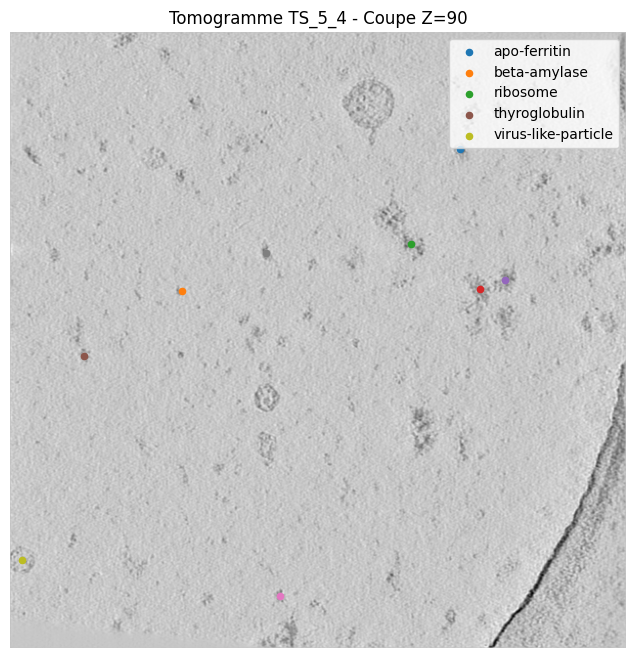

In [36]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# On suppose que les dictionnaires all_data et all_targets ont été générés par vos fonctions process_experiment_runs et load_targets.
# Par exemple :
#   all_data = process_experiment_runs(DATA_DIR)
#   all_targets = load_targets(TARGET_DIR)

voxel_size = 10  # Même valeur utilisée lors du chargement et de l'analyse

# Choisir un tomogramme et une résolution (ici, 'TS_5_4' et le groupe '0' pour la pleine résolution)
tomogram_folder = 'TS_5_4'
resolution_group = '0'
slice_index = 90  # Coupe à afficher sur l'axe Z

# Charger la coupe du tomogramme
tomogram_volume = all_data[tomogram_folder][resolution_group]['data']
image_slice = tomogram_volume[slice_index, :, :]

plt.figure(figsize=(8, 8))
plt.imshow(image_slice, cmap='gray')
plt.title(f"Tomogramme {tomogram_folder} - Coupe Z={slice_index}")

# Vérifier si des cibles (targets) sont présentes pour ce tomogramme
if tomogram_folder in all_targets:
    molecules = all_targets[tomogram_folder]
    
    # Pour éviter les doublons dans la légende
    legend_entries = {}
    
    for molecule, points in molecules.items():
        for point in points:
            # Extraction des coordonnées depuis la clé "location"
            x = point["location"]["x"] / voxel_size
            y = point["location"]["y"] / voxel_size
            z = point["location"]["z"] / voxel_size  # Coordonnée Z en voxels
            
            # N'afficher que les points proches de la coupe sélectionnée
            if abs(z - slice_index) < 3:  # Seuil ajustable selon la précision désirée
                sc = plt.scatter(x, y, s=20)
                if molecule not in legend_entries:
                    legend_entries[molecule] = sc

    if legend_entries:
        plt.legend(legend_entries.values(), legend_entries.keys(), loc='upper right')

plt.axis('off')
plt.show()



In [37]:
# same with napari

colors = {
    "apo-ferritin": 'red',
    "beta-amylase": 'green',
    "beta-galactosidase": 'blue',
    "ribosome": 'orange',
    "thyroglobulin": 'purple',
    "virus-like-particle": 'cyan',
    # Vous pouvez ajouter d'autres molécules si nécessaire.
}

import napari

# Choisir un tomogramme et une résolution (ici, 'TS_5_4' et le groupe '0' pour la pleine résolution)
tomogram_folder = 'TS_5_4'
resolution_group = '0'

# Charger le volume du tomogramme
tomogram_volume = all_data[tomogram_folder][resolution_group]['data']

# Créer une nouvelle instance Napari
viewer = napari.Viewer()

# Ajouter le volume du tomogramme
viewer.add_image(tomogram_volume, name=tomogram_folder)

# Ajouter les cibles (targets) si elles existent
if tomogram_folder in all_targets:
    molecules = all_targets[tomogram_folder]
    print(f"Chargement des cibles pour {tomogram_folder}...")
    print('Il y a', len(molecules), 'molécules')
    
    for molecule, points in molecules.items():
        print(f"  * {molecule}: {len(points)} points")
        points_array = np.array([
            [point["location"]["z"], point["location"]["y"], point["location"]["x"]]  # Permuter les axes X et Z
            for point in points
        ]) / voxel_size

        print("Shape du tomogramme:", tomogram_volume.shape)
        print("Min des points:", points_array.min(axis=0))
        print("Max des points:", points_array.max(axis=0))

        print("Il y a", len(points_array), "points")
        print("Premier point:", points_array[0])
        

        # Ajouter les points à la visualisation (petite sphère pour chaque point)
        viewer.add_points(points_array, name=molecule, size=13, face_color=colors.get(molecule, 'white'))
        
    # vérifier l'origine des axes (en haut à gauche dans napari)
    viewer.add_points(np.array([[0, 0, 0]]), name='origine', size=13, face_color='yellow')



# run the viewer
viewer.show()


Chargement des cibles pour TS_5_4...
Il y a 6 molécules
  * apo-ferritin: 46 points
Shape du tomogramme: (184, 630, 630)
Min des points: [  7.6321 104.9172  46.8514]
Max des points: [129.6612 591.5906 588.0769]
Il y a 46 points
Premier point: [ 60.4167 591.5906  46.8514]
  * beta-amylase: 10 points
Shape du tomogramme: (184, 630, 630)
Min des points: [ 27.9668 112.0574 102.5185]
Max des points: [128.0655 459.52   541.7091]
Il y a 10 points
Premier point: [ 56.7527 112.0574 541.7091]
  * beta-galactosidase: 12 points
Shape du tomogramme: (184, 630, 630)
Min des points: [ 5.     70.1502 45.5241]
Max des points: [124.954  522.0881 542.1651]
Il y a 12 points
Premier point: [ 37.1229  70.1502 195.9181]
  * ribosome: 31 points
Shape du tomogramme: (184, 630, 630)
Min des points: [24.4138 23.2123 69.164 ]
Max des points: [140.5435 615.071  507.2909]
Il y a 31 points
Premier point: [ 60.0934  60.1066 460.1271]
  * thyroglobulin: 30 points
Shape du tomogramme: (184, 630, 630)
Min des points: [1

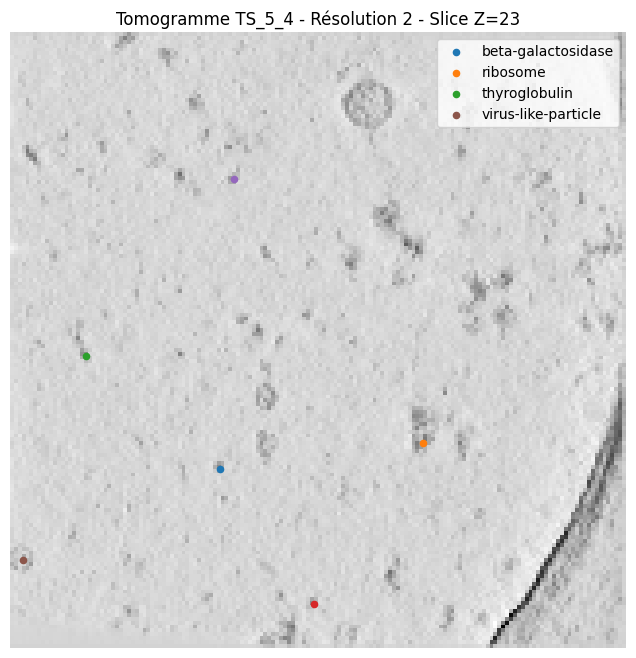

In [38]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# On suppose que les dictionnaires all_data et all_targets ont été générés par vos fonctions process_experiment_runs et load_targets.
# Par exemple :
#   all_data = process_experiment_runs(DATA_DIR)
#   all_targets = load_targets(TARGET_DIR)

# Pour la résolution 2, le voxel_size est 4 fois celui de la résolution 0 (4 * 10 = 40)
voxel_size = 40  
tomogram_folder = 'TS_5_4'
resolution_group = '2'
slice_index = 23  # Choix d'une slice au milieu du volume de résolution 2 (le volume a 46 slices)

# Charger la coupe du tomogramme à la résolution 2
tomogram_volume = all_data[tomogram_folder][resolution_group]['data']
image_slice = tomogram_volume[slice_index, :, :]

plt.figure(figsize=(8, 8))
plt.imshow(image_slice, cmap='gray')
plt.title(f"Tomogramme {tomogram_folder} - Résolution 2 - Slice Z={slice_index}")

# Vérifier si des cibles (targets) sont présentes pour ce tomogramme
if tomogram_folder in all_targets:
    molecules = all_targets[tomogram_folder]
    
    # Pour éviter les doublons dans la légende
    legend_entries = {}
    
    for molecule, points in molecules.items():
        for point in points:
            # Conversion des coordonnées physiques en indices voxels en divisant par voxel_size (40 à cette résolution)
            x = point["location"]["x"] / voxel_size
            y = point["location"]["y"] / voxel_size
            z = point["location"]["z"] / voxel_size  # Coordonnée Z en voxels
            
            # Afficher uniquement les points proches de la slice sélectionnée
            if abs(z - slice_index) < 0.75:
                sc = plt.scatter(x, y, s=20)
                if molecule not in legend_entries:
                    legend_entries[molecule] = sc

    if legend_entries:
        plt.legend(legend_entries.values(), legend_entries.keys(), loc='upper right')

plt.axis('off')
plt.show()


In [39]:
# --- PARTIE 2 : PRÉPARATION DES PATCHES ET DES MASQUES DE SEGMENTATION ---
import tensorflow as tf
voxel_size = 10  # Même valeur utilisée précédemment

# Mapping des molécules aux indices de classes.
# La classe 0 sera réservée au fond.
class_mapping = {
    "background": 0,
    "apo-ferritin": 1,
    "beta-amylase": 2,
    "ribosome": 3,
    "thyroglobulin": 4,
    "virus-like-particle": 5,
    "beta-galactosidase": 6
    # Vous pouvez ajouter d'autres molécules si nécessaire.
}

def generate_mask(volume_shape, targets, voxel_size, class_mapping, sphere_radius=2):
    """
    Crée un masque de segmentation (de dimensions volume_shape) à partir des targets.
    Pour chaque point, on convertit la position physique en indice voxel et on dessine
    une petite sphère (de rayon sphere_radius voxels) avec la classe correspondante.
    
    Args:
        volume_shape (tuple): Dimensions du volume (Z, Y, X).
        targets (dict): Dictionnaire des targets avec pour chaque molécule une liste de points.
        voxel_size (float): Facteur de conversion des coordonnées physiques en indices voxels.
        class_mapping (dict): Mapping de la molécule vers l'indice de classe (0 pour le fond, >0 pour les particules).
        sphere_radius (int): Rayon de la sphère (en voxels) à dessiner autour de chaque point.
        
    Returns:
        ndarray: Masque de segmentation de dimensions volume_shape.
    """
    mask = np.zeros(volume_shape, dtype=np.uint8)  # Fond = 0
    for molecule, points in targets.items():
        if molecule not in class_mapping:
            continue
        class_idx = class_mapping[molecule]
        for point in points:
            # Si le point est un dictionnaire avec la clé "location", on l'utilise
            if isinstance(point, dict) and "location" in point:
                x_coord = point["location"]["x"]
                y_coord = point["location"]["y"]
                z_coord = point["location"]["z"]
            else:
                # Sinon, on suppose que le point est une liste/tuple de coordonnées [x, y, z]
                x_coord, y_coord, z_coord = point
            
            x_center = int(round(x_coord / voxel_size))
            y_center = int(round(y_coord / voxel_size))
            z_center = int(round(z_coord / voxel_size))
            
            # Dessiner une petite sphère autour du point
            for dz in range(-sphere_radius, sphere_radius + 1):
                for dy in range(-sphere_radius, sphere_radius + 1):
                    for dx in range(-sphere_radius, sphere_radius + 1):
                        if dx**2 + dy**2 + dz**2 <= sphere_radius**2:
                            z_idx = z_center + dz
                            y_idx = y_center + dy
                            x_idx = x_center + dx
                            if (0 <= z_idx < volume_shape[0] and
                                0 <= y_idx < volume_shape[1] and
                                0 <= x_idx < volume_shape[2]):
                                mask[z_idx, y_idx, x_idx] = class_idx
    return mask

def extract_grid_patches(volume, mask, num_cubes_axis):
    """
    Extrait tous les patches qui couvrent entièrement le volume en divisant chaque dimension en num_cubes_axis segments.
    On suppose que le volume est exactement divisible par num_cubes_axis sur chaque axe.
    
    Args:
        volume (ndarray): Volume 3D d'entrée, de forme (Z, Y, X).
        mask (ndarray): Masque associé, de même forme.
        num_cubes_axis (int): Nombre de segments (patchs) par axe (exemple : 4 donnera 4x4x4 = 64 patches).
        
    Returns:
        tuple: (patches_img, patches_mask) 
               - patches_img : liste de patches d'image.
               - patches_mask : liste de patches de masque.
    """
    z_dim, y_dim, x_dim = volume.shape
    patch_size_z = z_dim // num_cubes_axis
    patch_size_y = y_dim // num_cubes_axis
    patch_size_x = x_dim // num_cubes_axis
    
    patches_img = []
    patches_mask = []
    
    for i in range(num_cubes_axis):
        for j in range(num_cubes_axis):
            for k in range(num_cubes_axis):
                z0 = i * patch_size_z
                y0 = j * patch_size_y
                x0 = k * patch_size_x
                patch_img = volume[z0:z0+patch_size_z, y0:y0+patch_size_y, x0:x0+patch_size_x]
                patch_mask = mask[z0:z0+patch_size_z, y0:y0+patch_size_y, x0:x0+patch_size_x]
                patches_img.append(patch_img)
                patches_mask.append(patch_mask)
    
    return patches_img, patches_mask



In [40]:
X_train_list = []
Y_train_list = []

# Ici, num_cubes_axis doit être choisi de façon à diviser exactement les dimensions du volume.
# Par exemple, pour le volume (184, 630, 630), on pourra choisir num_cubes_axis = 2 ou 4
# si les dimensions sont exactement divisibles par ce nombre.
num_cubes_axis = 2  # Exemple : divise le volume en 2x2x2 = 8 patches

for tomogram in dataset:
    volume = tomogram["images"][2]  # Utilisation de la résolution la plus fine
    mask_full = generate_mask(volume.shape, tomogram["targets"], voxel_size, class_mapping)
    print(f"Tomogramme {tomogram['name']} volume: {volume.shape}, masque: {mask_full.shape}")
    
    patches_img, patches_mask = extract_grid_patches(volume, mask_full, num_cubes_axis)
    
    for patch_img, patch_mask in zip(patches_img, patches_mask):
         # On ajoute la dimension de canal à l'image patch (le modèle attend (patch_size_z, patch_size_y, patch_size_x, 1))
         patch_img = patch_img[..., np.newaxis]
         X_train_list.append(patch_img)
         Y_train_list.append(patch_mask)

X_train = np.array(X_train_list, dtype=np.float32)
Y_train_int = np.array(Y_train_list, dtype=np.uint8)
print("X_train shape:", X_train.shape)
print("Y_train_int shape:", Y_train_int.shape)

# Conversion du masque en encodage one-hot (le modèle attend n_classes canaux en sortie)
Y_train = tf.keras.utils.to_categorical(Y_train_int, num_classes=7)
print("Y_train shape (one-hot):", Y_train.shape)

Tomogramme TS_5_4 volume: (46, 158, 158), masque: (46, 158, 158)
Tomogramme TS_69_2 volume: (46, 158, 158), masque: (46, 158, 158)
Tomogramme TS_6_4 volume: (46, 158, 158), masque: (46, 158, 158)
Tomogramme TS_6_6 volume: (46, 158, 158), masque: (46, 158, 158)
Tomogramme TS_73_6 volume: (46, 158, 158), masque: (46, 158, 158)
Tomogramme TS_86_3 volume: (46, 158, 158), masque: (46, 158, 158)
Tomogramme TS_99_9 volume: (46, 158, 158), masque: (46, 158, 158)
X_train shape: (56, 23, 79, 79, 1)
Y_train_int shape: (56, 23, 79, 79)
Y_train shape (one-hot): (56, 23, 79, 79, 7)


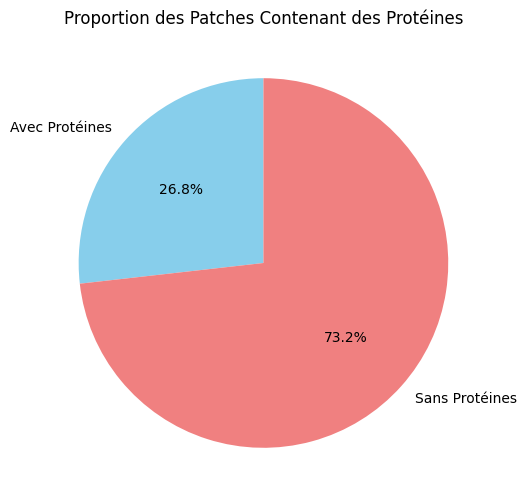

(15, 41, 56)

In [41]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

# Reload Y_train_int if available
# Assuming Y_train_int is available after the reset
# If not, you may need to redefine and reload the dataset

# Determine the presence of proteins in each patch (binary: 0 = background, 1 = contains proteins)
patch_contains_protein = (Y_train_int > 0).any(axis=(1, 2, 3))

# Compute proportions
num_patches = len(Y_train_int)
num_with_proteins = np.sum(patch_contains_protein)
num_without_proteins = num_patches - num_with_proteins

# Display as a pie chart
labels = ["Avec Protéines", "Sans Protéines"]
sizes = [num_with_proteins, num_without_proteins]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title("Proportion des Patches Contenant des Protéines")
plt.show()

# Display numerical results
num_with_proteins, num_without_proteins, num_patches


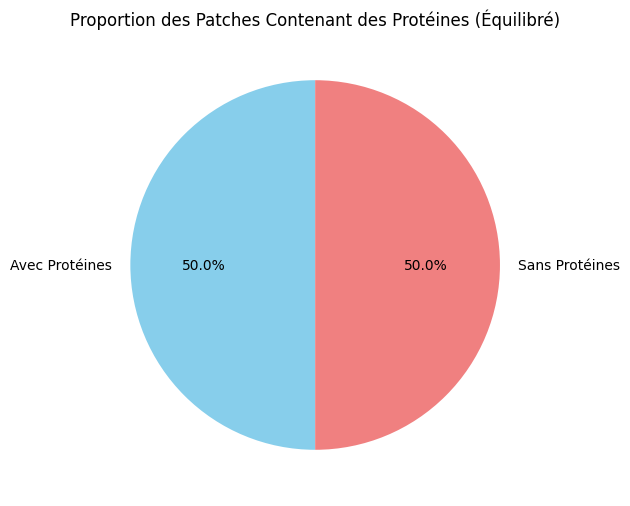

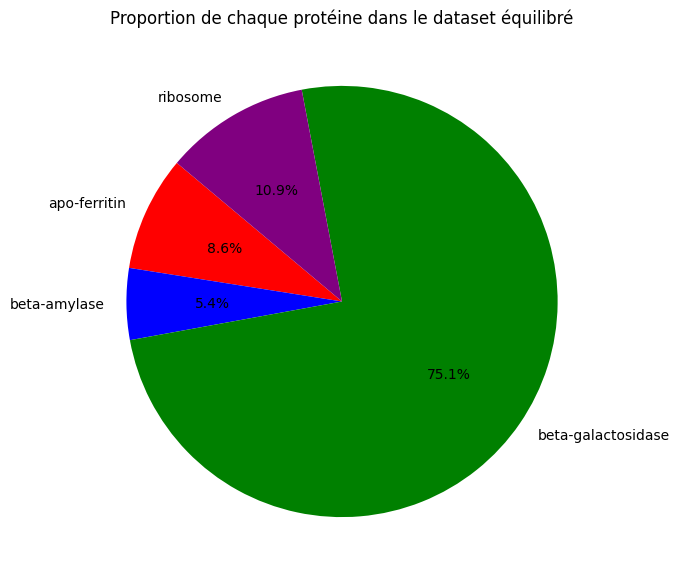

((30, 23, 79, 79, 1), (30, 23, 79, 79, 7))

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Déterminer les patchs qui contiennent des protéines (au moins un voxel avec une valeur > 0)
patch_contains_protein = (Y_train_int > 0).any(axis=(1, 2, 3))

# Séparer les indices des patchs avec et sans protéines
indices_with_protein = np.where(patch_contains_protein)[0]
indices_without_protein = np.where(~patch_contains_protein)[0]

# Déterminer combien de patchs sans protéines nous devons garder pour équilibrer à 50/50
num_with_protein = len(indices_with_protein)
num_without_protein_needed = num_with_protein  # Pour obtenir un équilibre 50/50

# Échantillonner aléatoirement les patchs sans protéines pour atteindre l'équilibre
indices_without_protein_sampled = np.random.choice(indices_without_protein, num_without_protein_needed, replace=False)

# Concaténer les indices des patchs sélectionnés
balanced_indices = np.concatenate([indices_with_protein, indices_without_protein_sampled])

# Mélanger les indices pour éviter tout biais d'ordre
np.random.shuffle(balanced_indices)

# Construire les nouveaux ensembles X_train et Y_train équilibrés
X_train_balanced = X_train[balanced_indices]
Y_train_int_balanced = Y_train_int[balanced_indices]

# Conversion du masque en encodage one-hot (le modèle attend n_classes canaux en sortie)
Y_train_balanced = tf.keras.utils.to_categorical(Y_train_int_balanced, num_classes=7)

# Vérifier les nouvelles proportions
num_patches_balanced = len(Y_train_int_balanced)
num_with_proteins_balanced = np.sum((Y_train_int_balanced > 0).any(axis=(1, 2, 3)))
num_without_proteins_balanced = num_patches_balanced - num_with_proteins_balanced

# Affichage des proportions sous forme de camembert
labels = ["Avec Protéines", "Sans Protéines"]
sizes = [num_with_proteins_balanced, num_without_proteins_balanced]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title("Proportion des Patches Contenant des Protéines (Équilibré)")
plt.show()

# Affichage des proportions des classes (protéines spécifiques)
unique_classes, counts = np.unique(Y_train_int_balanced[Y_train_int_balanced > 0], return_counts=True)

# Mapping des classes vers les noms de protéines
class_labels = {
    0: "background",
    1: "apo-ferritin",
    2: "beta-amylase",
    3: "beta-galactosidase",
    4: "ribosome",
    5: "thyroglobulin",
    6: "virus-like-particle",
    7: "beta-galactosidase"
}

# Convertir indices de classes en noms
labels = [class_labels.get(int(cls), f"Classe {cls}") for cls in unique_classes]
sizes = counts

# Affichage des proportions des protéines sous forme de camembert
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['red', 'blue', 'green', 'purple', 'orange', 'cyan'], startangle=140)
plt.title("Proportion de chaque protéine dans le dataset équilibré")
plt.show()

# Afficher les tailles finales
X_train_balanced.shape, Y_train_balanced.shape


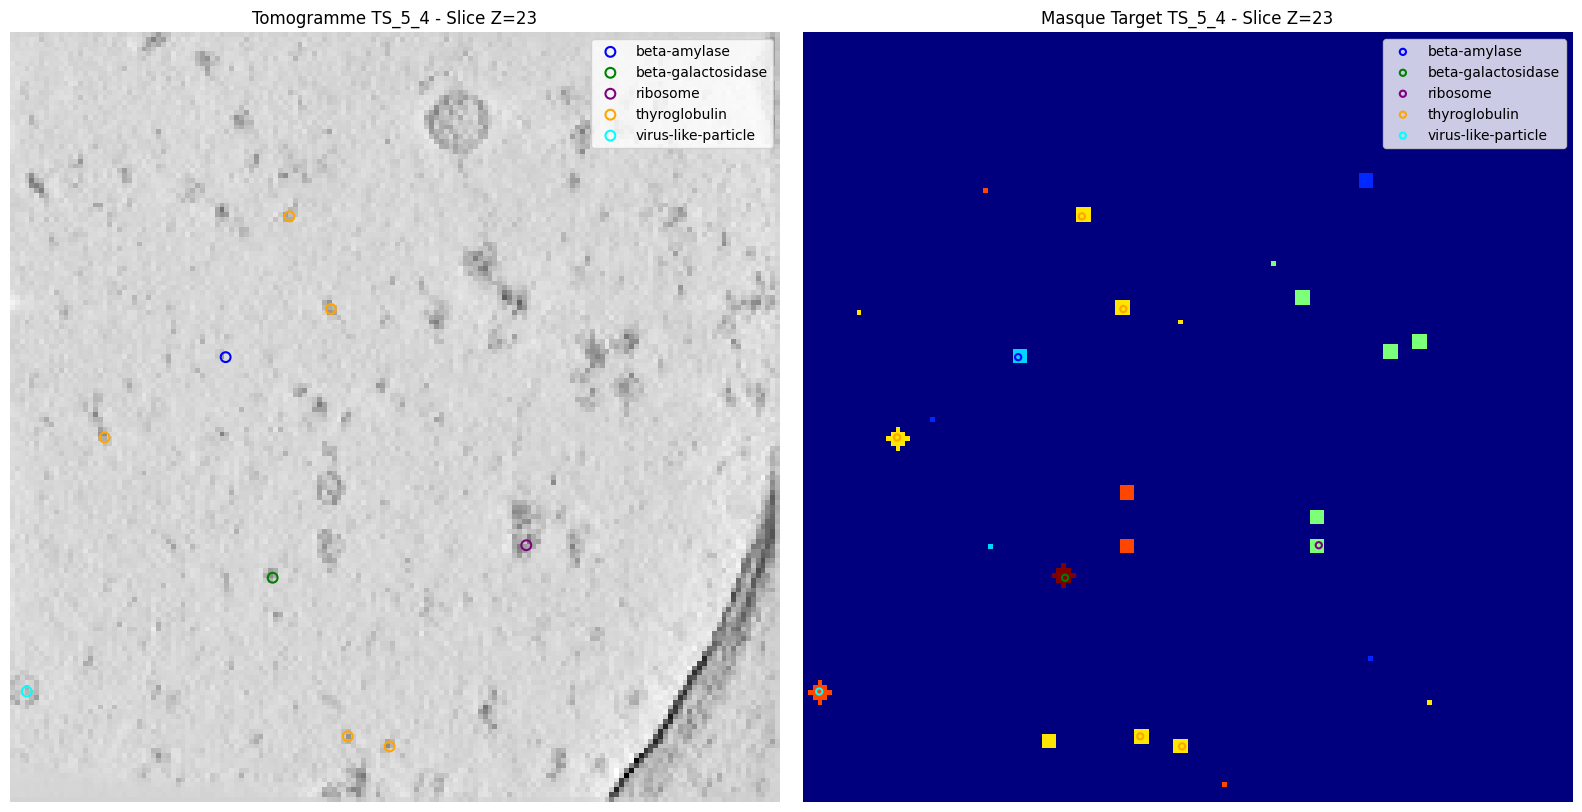

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def display_tomogram_and_target(all_data, all_targets, tomogram_folder, resolution_group, slice_index, voxel_size, class_mapping, sphere_radius=2):
    """
    Affiche côte à côte la coupe du tomogramme et le masque target associé.
    """
    # Charger le volume et extraire la coupe
    volume = all_data[tomogram_folder][resolution_group]['data']
    image_slice = volume[slice_index, :, :]
    
    # Générer le masque complet à partir des targets
    mask_full = generate_mask(volume.shape, all_targets.get(tomogram_folder, {}), voxel_size, class_mapping, sphere_radius)
    target_slice = mask_full[slice_index, :, :]

    # Création de la figure avec deux sous-graphes
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Palette de couleurs fixe pour chaque molécule
    colors = {
        "apo-ferritin": "red",
        "beta-amylase": "blue",
        "ribosome": "purple",
        "thyroglobulin": "orange",
        "virus-like-particle": "cyan",
        "beta-galactosidase": "green"
    }
    
    # --- Affichage de la coupe du tomogramme avec les targets ---
    axs[0].imshow(image_slice, cmap='gray')
    axs[0].set_title(f"Tomogramme {tomogram_folder} - Slice Z={slice_index}")

    legend_entries = {}
    targets = all_targets.get(tomogram_folder, {})

    for molecule, points in targets.items():
        color = colors.get(molecule, "yellow")  # Assurer une couleur par défaut si inconnue
        for point in points:
            x = point["location"]["x"] / voxel_size
            y = point["location"]["y"] / voxel_size
            z = point["location"]["z"] / voxel_size
            if abs(z - slice_index) < 1:
                sc = axs[0].scatter(x, y, s=50, edgecolors=color, facecolors='none', linewidths=1.5)
                if molecule not in legend_entries:
                    legend_entries[molecule] = sc

    if legend_entries:
        axs[0].legend(legend_entries.values(), legend_entries.keys(), loc='upper right')
    axs[0].axis('off')

    # --- Affichage du masque généré ---
    axs[1].imshow(target_slice, cmap='jet')
    axs[1].set_title(f"Masque Target {tomogram_folder} - Slice Z={slice_index}")

    legend_entries_mask = {}
    for molecule, points in targets.items():
        color = colors.get(molecule, "yellow")
        for point in points:
            x = point["location"]["x"] / voxel_size
            y = point["location"]["y"] / voxel_size
            z = point["location"]["z"] / voxel_size
            if abs(z - slice_index) < 1:
                sc = axs[1].scatter(x, y, s=20, edgecolors=color, facecolors='none', linewidths=1.5)
                if molecule not in legend_entries_mask:
                    legend_entries_mask[molecule] = sc

    if legend_entries_mask:
        axs[1].legend(legend_entries_mask.values(), legend_entries_mask.keys(), loc='upper right')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


# --- Exemple d'utilisation ---
# On suppose que all_data et all_targets ont été générés précédemment,
# et que class_mapping est défini (comme dans l'exemple fourni).
voxel_size = 40
tomogram_folder = 'TS_5_4'
resolution_group = '2'
slice_index = 23

display_tomogram_and_target(all_data, all_targets, tomogram_folder, resolution_group, slice_index, voxel_size, class_mapping, sphere_radius=2)


In [44]:
print(X_train_balanced.shape)
print(Y_train_balanced.shape)

(30, 23, 79, 79, 1)
(30, 23, 79, 79, 7)


In [45]:
import numpy as np

# Afficher les valeurs uniques présentes dans Y_train (données segmentées)
unique_values = np.unique(Y_train_int)  # Y_train_int est la version non one-hot de Y_train

unique_values


array([0, 1, 2, 3, 4], dtype=uint8)

In [46]:
from sklearn.model_selection import train_test_split

# 1. Séparer X_train_balanced et Y_train_balanced en train + temp (80% - 20%)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_train_balanced, Y_train_balanced, test_size=0.2, random_state=42)

# 2. Séparer X_temp et Y_temp en validation et test (50% pour chacun de la partie 20%)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42)

# Afficher les tailles des splits
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Train set: (24, 23, 79, 79, 1), Validation set: (3, 23, 79, 79, 1), Test set: (3, 23, 79, 79, 1)


In [47]:
print("Y_train contient NaN ?", np.isnan(Y_train).any())
print("X_train contient NaN ?", np.isnan(X_train).any())


Y_train contient NaN ? False
X_train contient NaN ? False


In [48]:
# def protein_accuracy(y_true, y_pred):
#     y_true_labels = tf.argmax(y_true, axis=-1)
#     y_pred_labels = tf.argmax(y_pred, axis=-1)
#     mask = tf.not_equal(y_true_labels, 0)
#     correct = tf.equal(y_true_labels, y_pred_labels)
#     correct_masked = tf.boolean_mask(correct, mask)
    
#     # Si aucun voxel de protéine n'est présent, retourner 0 pour éviter NaN.
#     return tf.cond(tf.equal(tf.size(correct_masked), 0),
#                    lambda: tf.constant(0.0, dtype=tf.float32),
#                    lambda: tf.reduce_mean(tf.cast(correct_masked, tf.float32)))


def protein_accuracy(y_true, y_pred):
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    mask = tf.not_equal(y_true_labels, 0)
    correct = tf.equal(y_true_labels, y_pred_labels)
    correct_masked = tf.boolean_mask(correct, mask)

    return tf.reduce_sum(tf.cast(correct_masked, tf.float32)) / tf.maximum(1.0, tf.reduce_sum(tf.cast(mask, tf.float32)))



In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Concatenate, Dropout, BatchNormalization, Activation, ZeroPadding3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.saving import register_keras_serializable


# Vos poids de classe pour les protéines (les clés correspondent aux noms de molécules)
protein_weights = {
    'background': 0.001,
    'apo-ferritin': 1,
    'beta-amylase': 0.5,
    'beta-galactosidase': 1.5,
    'ribosome': 1,
    'thyroglobulin': 1.5,
    'virus-like-particle': 1,
}


# Mapping des molécules vers leurs indices (classe 0 = fond)
class_mapping = {
    "background": 0,
    "apo-ferritin": 1,
    "beta-amylase": 2,
    "ribosome": 3,
    "thyroglobulin": 4,
    "virus-like-particle": 5,
    "beta-galactosidase": 6
}
# On suppose ici que le nombre total de classes (background + protéines) est 7.
n_classes = 7


@register_keras_serializable()
def weighted_categorical_crossentropy(weights_dict, class_mapping, num_classes):
    """
    Fonction de perte pondérée qui ignore le fond (classe 0).
    """
    weight_vector = np.ones(num_classes, dtype=np.float32)
    for molecule, class_idx in class_mapping.items():
        if molecule in weights_dict:
            weight_vector[class_idx] = weights_dict[molecule]
    weight_vector = tf.constant(weight_vector, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        loss_unweighted = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        # Exclure les voxels de classe 0 (fond)
        true_class = tf.argmax(y_true, axis=-1)
        mask = tf.not_equal(true_class, 0)
        voxel_weights = tf.gather(weight_vector, true_class)
        weighted_loss = loss_unweighted * voxel_weights

        # Appliquer le masque : ne considérer que les protéines
        masked_loss = tf.boolean_mask(weighted_loss, mask)

        return tf.cond(
            tf.greater(tf.size(masked_loss), 0),  
            lambda: tf.reduce_mean(masked_loss),  
            lambda: tf.constant(0.0, dtype=tf.float32)
        )

    return loss



def conv_block(inputs, n_filters, dropout=0, batch_norm=True):
    x = Conv3D(n_filters, kernel_size=3, padding='same')(inputs)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(n_filters, kernel_size=3, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x

def unet3d_model(input_shape, n_classes, filters=[16, 32, 64], dropout=0):
    inputs = Input(input_shape)
    # Encoder
    c1 = conv_block(inputs, filters[0], dropout)
    p1 = MaxPooling3D(pool_size=(2,2,2), padding="same")(c1)
    
    c2 = conv_block(p1, filters[1], dropout)
    p2 = MaxPooling3D(pool_size=(2,2,2), padding="same")(c2)
    
    c3 = conv_block(p2, filters[2], dropout)
    p3 = MaxPooling3D(pool_size=(2,2,2), padding="same")(c3)
    
    # Bottleneck
    c4 = conv_block(p3, filters[2]*2, dropout)
    # Decoder
    u3 = UpSampling3D(size=(2,2,2))(c4)
    # Ici, c3 a été obtenu avec padding="same". On s'attend à ce que u3 et c3 aient les mêmes dimensions.
    u3 = Concatenate()([u3, c3])
    c5 = conv_block(u3, filters[2], dropout)
    
    u2 = UpSampling3D(size=(2,2,2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = conv_block(u2, filters[1], dropout)
    
    u1 = UpSampling3D(size=(2,2,2))(c6)
    # On remarque que la dimension spatiale de u1 est calculée par multiplication par 2,
    # ce qui peut donner une taille légèrement différente de celle de c1.
    # Par exemple, avec une entrée de (23,79,79), u1 pourrait avoir (24,80,80).
    # On applique alors un ZeroPadding3D sur c1 pour l'ajuster.
    c1_pad = ZeroPadding3D(padding=((0,1), (0,1), (0,1)))(c1)
    u1 = Concatenate()([u1, c1_pad])
    c7 = conv_block(u1, filters[0], dropout)


    # Cropping pour ajuster la taille finale
    output_crop = Cropping3D(cropping=((0,1), (0,1), (0,1)))(c7)
    outputs = Conv3D(n_classes, kernel_size=1, activation='softmax')(output_crop)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Paramètres d'entrée adaptés à votre cas (par exemple, avec des patches de résolution 2)
input_shape = (23, 79, 79, 1)
n_classes = 7
filters = [16, 32, 64]
dropout = 0

loss_fn = weighted_categorical_crossentropy(protein_weights, class_mapping, n_classes)



In [50]:
from tensorflow.keras.callbacks import EarlyStopping

model = unet3d_model(input_shape, n_classes, filters, dropout)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=loss_fn,
              metrics=['accuracy', protein_accuracy])

model.summary()

# Créer un callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # On surveille la perte sur le set de validation
                                patience=5,         # Si la perte ne baisse pas pendant 5 époques, on arrête
                                verbose=1,          # Affiche des informations sur l'arrêt anticipé
                                restore_best_weights=True)  # Restaure les poids du meilleur modèle

# Entraînement avec early stopping
history = model.fit(X_train, Y_train,
                    batch_size=1,
                    epochs=20,
                    validation_data=(X_val, Y_val),  # N'oublie pas d'ajouter un jeu de validation
                    callbacks=[early_stopping])  # Ajout du callback EarlyStopping

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 23, 79,    │          0 │ -                 │
│ (InputLayer)        │ 79, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 23, 79,    │        448 │ input_layer_1[0]… │
│                     │ 79, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 79,    │         64 │ conv3d_15[0][0]   │
│ (BatchNormalizatio… │ 79, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 23, 79,    │          0 │ batch_normalizat… │
│ (Activation)        │ 79, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 23, 79,    │      6,928 │ activation_14[0]… │
│                     │ 79, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 79,    │         64 │ conv3d_16[0][0]   │
│ (BatchNormalizatio… │ 79, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 23, 79,    │          0 │ batch_normalizat… │
│ (Activation)        │ 79, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 12, 40,    │          0 │ activation_15[0]… │
│ (MaxPooling3D)      │ 40, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 12, 40,    │     13,856 │ max_pooling3d_3[… │
│                     │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 40,    │        128 │ conv3d_17[0][0]   │
│ (BatchNormalizatio… │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 12, 40,    │          0 │ batch_normalizat… │
│ (Activation)        │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 12, 40,    │     27,680 │ activation_16[0]… │
│                     │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 40,    │        128 │ conv3d_18[0][0]   │
│ (BatchNormalizatio… │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 12, 40,    │          0 │ batch_normalizat… │
│ (Activation)        │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 6, 20, 20, │          0 │ activation_17[0]… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 6, 20, 20, │     55,360 │ max_pooling3d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 20, 20, │        256 │ conv3d_19[0][0] 

 Total params: 1,462,503 (5.58 MB)

 Trainable params: 1,461,095 (5.57 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - accuracy: 0.1455 - loss: 1.1092 - protein_accuracy: 0.1241 - val_accuracy: 0.0647 - val_loss: 0.3211 - val_protein_accuracy: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.1536 - loss: 1.4370 - protein_accuracy: 0.2830 - val_accuracy: 0.0570 - val_loss: 0.3153 - val_protein_accuracy: 0.0707
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.1413 - loss: 0.8544 - protein_accuracy: 0.4114 - val_accuracy: 0.0629 - val_loss: 0.3027 - val_protein_accuracy: 0.3232
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.1381 - loss: 0.4545 - protein_accuracy: 0.3147 - val_accuracy: 0.0284 - val_loss: 0.2849 - val_protein_accuracy: 0.3333
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.1381 - loss: 0.3568 - protein_accuracy: 0.4761 - val_accuracy: 0.0293 - val_loss: 0.2663 - val_protein_accuracy: 0.3333
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - accura

In [55]:
# Sauvegarde du modèle entraîné (modèle complet, y compris l'architecture, les poids et les paramètres d'optimisation et fonction de perte)
model.save('unet3d_trained_model.keras')

In [ ]:
# Redéfinir la fonction de perte pour l'utiliser dans le chargement du modèle
loss_fn = weighted_categorical_crossentropy(protein_weights, class_mapping, n_classes)

# Charger le modèle avec la bonne fonction de perte et la métrique personnalisée
model = tf.keras.models.load_model(
    "unet3d_trained_model.keras",
    custom_objects={
        "protein_accuracy": protein_accuracy,
        "loss": loss_fn
    }
)



# Vérifier que le modèle est bien chargé
model.summary()


In [51]:
# Sélectionner un patch au hasard dans X_test
index = np.random.randint(0, len(X_test))

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 🔹 **Palette de couleurs pour les protéines**
colors = {
    0: "gray",
    1: "red",
    2: "blue",
    3: "green",
    4: "purple",
    5: "orange",
    6: "cyan",
}

# 🔹 **Mapping des classes vers les noms des protéines**
class_labels = {
    0: "Fond",
    1: "apo-ferritin",
    2: "beta-amylase",
    3: "ribosome",
    4: "thyroglobulin",
    5: "virus-like-particle",
    6: "beta-galactosidase"
}

# Sélectionner un patch au hasard dans X_train
index = np.random.randint(0, len(X_train))

# Extraire le patch d'entraînement
x_sample = X_train[index]  # (23, 79, 79, 1)
y_true = Y_train[index]    # (23, 79, 79, 8) -> One-hot

# Ajouter une dimension batch pour la prédiction
x_sample_expanded = np.expand_dims(x_sample, axis=0)

# Effectuer la prédiction
y_pred = model.predict(x_sample_expanded)

# Convertir y_pred en indices de classes (prendre la classe avec la plus haute probabilité)
y_pred_classes = np.argmax(y_pred[0], axis=-1)  # (23, 79, 79)
y_true_classes = np.argmax(y_true, axis=-1)  # (23, 79, 79)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


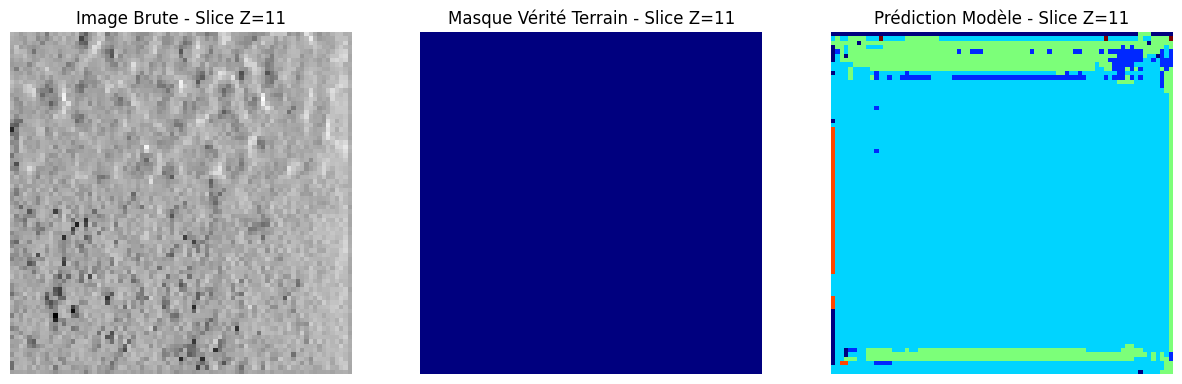

In [ ]:
def display_prediction(x_sample, y_true_classes, y_pred_classes, slice_index=11):
    """
    Affiche une coupe du patch testé, avec :
    - L'image brute (X_test)
    - Le masque réel (Y_test)
    - La prédiction du modèle (Y_pred)
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Image brute
    axs[0].imshow(x_sample[slice_index, :, :, 0], cmap="gray")
    axs[0].set_title(f"Image Brute - Slice Z={slice_index}")
    axs[0].axis("off")

    # Masque de vérité terrain (Y_test)
    axs[1].imshow(y_true_classes[slice_index, :, :], cmap="jet")
    axs[1].set_title(f"Masque Vérité Terrain - Slice Z={slice_index}")
    axs[1].axis("off")

    # Prédiction du modèle (Y_pred)
    axs[2].imshow(y_pred_classes[slice_index, :, :], cmap="jet")
    axs[2].set_title(f"Prédiction Modèle - Slice Z={slice_index}")
    axs[2].axis("off")

    plt.show()

# Afficher les résultats pour une coupe Z donnée
display_prediction(x_sample, y_true_classes, y_pred_classes, slice_index=11)



In [54]:
# same with napari
def display_patch_napari(x_sample, y_true_classes, y_pred_classes):
    """
    Affiche un patch 3D dans Napari avec l'image brute, le masque réel et la prédiction du modèle.
    """
    import napari

    # Créer une nouvelle instance Napari
    viewer = napari.Viewer()

    # Ajouter l'image brute
    viewer.add_image(x_sample, name='Image brute', colormap='gray')

    # Ajouter le masque de vérité terrain
    viewer.add_labels(y_true_classes, name='Masque Vérité Terrain', opacity=0.5)

    # Ajouter la prédiction du modèle
    viewer.add_labels(y_pred_classes, name='Prédiction Modèle', opacity=0.5)

    # Exécuter Napari
    viewer.show()

# Afficher le patch dans Napari
display_patch_napari(x_sample, y_true_classes, y_pred_classes)
